In [1]:
import os

proxy = 'http://proxy-k.ecl.ntt.co.jp:8080'

os.environ['http_proxy'] = proxy 
os.environ['HTTP_PROXY'] = proxy
os.environ['https_proxy'] = proxy
os.environ['HTTPS_PROXY'] = proxy

In [2]:

import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler


class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        # loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in dataset:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                self.used_label_indices_count[class_]:self.used_label_indices_count[
                    class_] + self.n_samples])
                
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > \
                    len(self.label_to_indices[class_]):

                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0

            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size



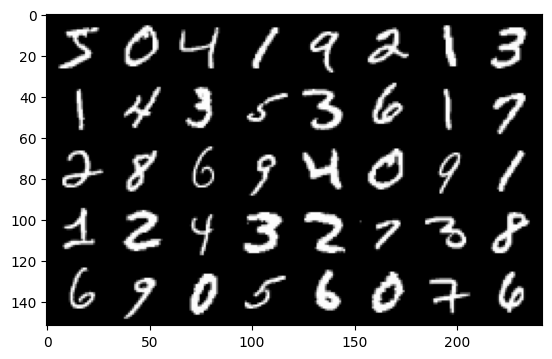

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

n_classes = 5
n_samples = 8

mnist_train =  torchvision.datasets.MNIST(root="mnist/mnist_train", train=True, download=True, transform=transforms.Compose([transforms.ToTensor(),]))

balanced_batch_sampler = BalancedBatchSampler(mnist_train, n_classes, n_samples)

# dataloader = torch.utils.data.DataLoader(mnist_train, batch_sampler=balanced_batch_sampler)
dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=40)
my_testiter = iter(dataloader)
images, target = next(my_testiter)


def imshow(img):    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

imshow(torchvision.utils.make_grid(images))

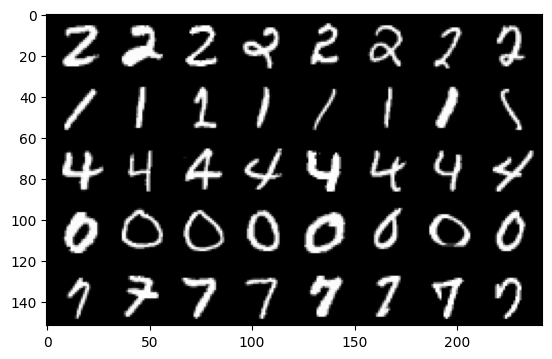

In [4]:
dataloader = torch.utils.data.DataLoader(mnist_train, batch_sampler=balanced_batch_sampler)
my_testiter = iter(dataloader)
images, target = next(my_testiter)

imshow(torchvision.utils.make_grid(images))


In [7]:

class BalancedSampler(torch.utils.data.Sampler):
    def __init__(self,
                 dataset: torch.utils.data.Dataset,
                 n_classes, 
                 n_samples):
        self.labels_list = []
        for _, label in dataset:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    
    def __iter__(self):
        self.count = 0
        classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
        indices = []
        for class_ in classes:
            indices.extend(self.label_to_indices[class_][
                self.used_label_indices_count[class_]:self.used_label_indices_count[
                    class_] + self.n_samples])
            
        return iter(indices)
    
    def __len__(self):
        return self.batch_size



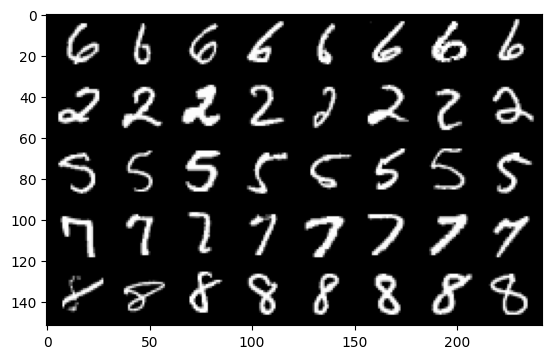

In [11]:
sampler = BalancedSampler(mnist_train, n_classes, n_samples)
dataloader = torch.utils.data.DataLoader(mnist_train, sampler=sampler, batch_size= n_classes * n_samples)
my_testiter = iter(dataloader)
images, target = next(my_testiter)

imshow(torchvision.utils.make_grid(images))

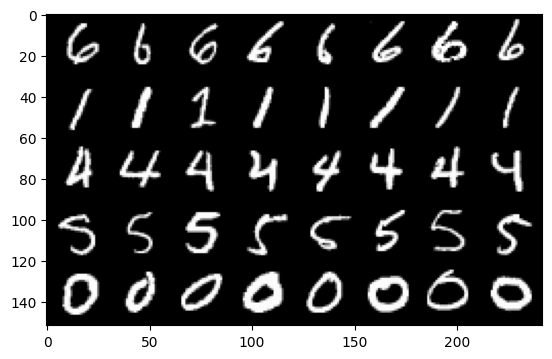

In [14]:
my_testiter = iter(dataloader)
images, target = next(my_testiter)

imshow(torchvision.utils.make_grid(images))